In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from water_pollution.data.preproc import *
from water_pollution.data import stations
from water_pollution.data import stations

from water_pollution.data import visu

In [5]:
# Builds the small df (from saone data between 2011-2021)
file_path = '../../raw_data/pc_saone_2011_2021/Analyses.CSV'
rawdf = get_rawdf_from_file(file_path)
small_training_df = build_saone_base_training_data(rawdf)


In [25]:
small_training_df

,date,year,sin_doy,cos_doy,station_id,source_dist,nitrate
0,2013-01-28,2013,0.448229,0.893919,6000990,5.827388,4.3
1,2013-03-25,2013,0.989932,0.141540,6000990,5.827388,3.8
2,2013-05-29,2013,0.559589,-0.828770,6000990,5.827388,3.5
3,2013-07-22,2013,-0.329408,-0.944188,6000990,5.827388,4.9
4,2013-09-23,2013,-0.988678,-0.150055,6000990,5.827388,5.1
...,...,...,...,...,...,...,...
1875,2021-04-07,2021,0.996659,-0.081676,6810010,236.942892,11.0
1876,2021-05-28,2021,0.573772,-0.819015,6810010,236.942892,9.0
1877,2021-06-25,2021,0.128748,-0.991677,6810010,236.942892,7.8
1878,2021-07-29,2021,-0.440519,-0.897743,6810010,236.942892,7.4


In [7]:
# stationsdf = stations.get_saone_stations_df()
# stationsdf.sort_values('alt')

In [9]:
from tensorflow.keras import models, layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

In [51]:
df

,date,year,sin_doy,cos_doy,station_id,source_dist,nitrate
0,2013-01-28,2013,0.448229,0.893919,6000990,5.827388,4.3
1,2013-03-25,2013,0.989932,0.141540,6000990,5.827388,3.8
2,2013-05-29,2013,0.559589,-0.828770,6000990,5.827388,3.5
3,2013-07-22,2013,-0.329408,-0.944188,6000990,5.827388,4.9
4,2013-09-23,2013,-0.988678,-0.150055,6000990,5.827388,5.1
...,...,...,...,...,...,...,...
1875,2021-04-07,2021,0.996659,-0.081676,6810010,236.942892,11.0
1876,2021-05-28,2021,0.573772,-0.819015,6810010,236.942892,9.0
1877,2021-06-25,2021,0.128748,-0.991677,6810010,236.942892,7.8
1878,2021-07-29,2021,-0.440519,-0.897743,6810010,236.942892,7.4


In [42]:
df = small_training_df.copy()

# TRAIN / TEST / VAL SPLIT

feature_cols = [
    'sin_doy',
    'cos_doy',
    #'source_dist',
    #'year',
]

# SAONE A APREMONT 1 kept for final validation
val_bool = df['station_id'] == 6005500
val_df = df[val_bool].sort_values('date')

learn_bool = df['station_id'] != 6005500
learn_df = df[learn_bool].sort_values('date')


X = learn_df[feature_cols]
y = learn_df['nitrate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

X_val = val_df[feature_cols]
y_val = val_df['nitrate']

In [43]:
assert df.shape[0] == learn_df.shape[0] + val_df.shape[0]
assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]

In [44]:
# PREPROCESSING

# Fit on X_train
scaler = StandardScaler()
scaler.fit(X_train)

# Transform all the X
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)
X_val_sc = scaler.transform(X_val)


In [45]:
def init_model(X):
    
    model = models.Sequential()
    
    model.add(layers.Dense(20,activation='relu',input_dim=X.shape[1]))
    model.add(layers.Dense(30,activation='relu'))
    model.add(layers.Dense(10,activation='relu'))
    
    model.add(layers.Dense(1,activation='linear'))
    
    return model

model = init_model(X)
model.compile(loss='mse', optimizer='adam')

es = EarlyStopping(
	patience=500,
	monitor='val_loss',
	restore_best_weights=True
)

history = model.fit(
	X_train_sc,y_train,
	epochs=10000,  # set it to a large value, early stoping will stop the fit
	batch_size=32, # good values : 16 or 32
	callbacks=[es],
	validation_data=(X_test, y_test),
	verbose=2
)

Epoch 1/10000
38/38 - 0s - loss: 95.0462 - val_loss: 88.7229
Epoch 2/10000
38/38 - 0s - loss: 74.0446 - val_loss: 60.3328
Epoch 3/10000
38/38 - 0s - loss: 30.0072 - val_loss: 20.6670
Epoch 4/10000
38/38 - 0s - loss: 11.6776 - val_loss: 15.9996
Epoch 5/10000
38/38 - 0s - loss: 10.8525 - val_loss: 16.0598
Epoch 6/10000
38/38 - 0s - loss: 10.6918 - val_loss: 15.8576
Epoch 7/10000
38/38 - 0s - loss: 10.5913 - val_loss: 15.6509
Epoch 8/10000
38/38 - 0s - loss: 10.5260 - val_loss: 15.8306
Epoch 9/10000
38/38 - 0s - loss: 10.4939 - val_loss: 15.3496
Epoch 10/10000
38/38 - 0s - loss: 10.4581 - val_loss: 15.2775
Epoch 11/10000
38/38 - 0s - loss: 10.4294 - val_loss: 15.6507
Epoch 12/10000
38/38 - 0s - loss: 10.4233 - val_loss: 14.9370
Epoch 13/10000
38/38 - 0s - loss: 10.4314 - val_loss: 15.8797
Epoch 14/10000
38/38 - 0s - loss: 10.4249 - val_loss: 14.3454
Epoch 15/10000
38/38 - 0s - loss: 10.4412 - val_loss: 15.9336
Epoch 16/10000
38/38 - 0s - loss: 10.3659 - val_loss: 15.9439
Epoch 17/10000
38

Epoch 134/10000
38/38 - 0s - loss: 9.7983 - val_loss: 15.7653
Epoch 135/10000
38/38 - 0s - loss: 9.7783 - val_loss: 15.9236
Epoch 136/10000
38/38 - 0s - loss: 9.8196 - val_loss: 16.7027
Epoch 137/10000
38/38 - 0s - loss: 9.8066 - val_loss: 15.1500
Epoch 138/10000
38/38 - 0s - loss: 9.7782 - val_loss: 15.3952
Epoch 139/10000
38/38 - 0s - loss: 9.8045 - val_loss: 15.1867
Epoch 140/10000
38/38 - 0s - loss: 9.8117 - val_loss: 14.0341
Epoch 141/10000
38/38 - 0s - loss: 9.8580 - val_loss: 14.9593
Epoch 142/10000
38/38 - 0s - loss: 9.7871 - val_loss: 15.5533
Epoch 143/10000
38/38 - 0s - loss: 9.7686 - val_loss: 16.3921
Epoch 144/10000
38/38 - 0s - loss: 9.7484 - val_loss: 15.0547
Epoch 145/10000
38/38 - 0s - loss: 9.7863 - val_loss: 14.3498
Epoch 146/10000
38/38 - 0s - loss: 9.7611 - val_loss: 15.3032
Epoch 147/10000
38/38 - 0s - loss: 9.7347 - val_loss: 15.7482
Epoch 148/10000
38/38 - 0s - loss: 9.7529 - val_loss: 15.1807
Epoch 149/10000
38/38 - 0s - loss: 9.7507 - val_loss: 15.2036
Epoch 15

38/38 - 0s - loss: 9.3245 - val_loss: 15.2647
Epoch 267/10000
38/38 - 0s - loss: 9.3979 - val_loss: 15.1985
Epoch 268/10000
38/38 - 0s - loss: 9.3296 - val_loss: 15.2963
Epoch 269/10000
38/38 - 0s - loss: 9.3719 - val_loss: 15.5528
Epoch 270/10000
38/38 - 0s - loss: 9.3836 - val_loss: 15.6943
Epoch 271/10000
38/38 - 0s - loss: 9.4037 - val_loss: 15.7754
Epoch 272/10000
38/38 - 0s - loss: 9.4181 - val_loss: 15.7889
Epoch 273/10000
38/38 - 0s - loss: 9.3431 - val_loss: 15.2466
Epoch 274/10000
38/38 - 0s - loss: 9.3297 - val_loss: 16.2462
Epoch 275/10000
38/38 - 0s - loss: 9.3672 - val_loss: 15.6442
Epoch 276/10000
38/38 - 0s - loss: 9.3180 - val_loss: 16.1579
Epoch 277/10000
38/38 - 0s - loss: 9.3082 - val_loss: 16.0771
Epoch 278/10000
38/38 - 0s - loss: 9.3053 - val_loss: 15.7315
Epoch 279/10000
38/38 - 0s - loss: 9.4772 - val_loss: 16.9586
Epoch 280/10000
38/38 - 0s - loss: 9.5616 - val_loss: 16.5428
Epoch 281/10000
38/38 - 0s - loss: 9.4255 - val_loss: 14.8806
Epoch 282/10000
38/38 - 

Epoch 399/10000
38/38 - 0s - loss: 9.1408 - val_loss: 16.3471
Epoch 400/10000
38/38 - 0s - loss: 9.2718 - val_loss: 16.0238
Epoch 401/10000
38/38 - 0s - loss: 9.1505 - val_loss: 17.5236
Epoch 402/10000
38/38 - 0s - loss: 9.2239 - val_loss: 15.4993
Epoch 403/10000
38/38 - 0s - loss: 9.1468 - val_loss: 16.7326
Epoch 404/10000
38/38 - 0s - loss: 9.2386 - val_loss: 15.8671
Epoch 405/10000
38/38 - 0s - loss: 9.1834 - val_loss: 16.2334
Epoch 406/10000
38/38 - 0s - loss: 9.2366 - val_loss: 15.1896
Epoch 407/10000
38/38 - 0s - loss: 9.2640 - val_loss: 16.6066
Epoch 408/10000
38/38 - 0s - loss: 9.2490 - val_loss: 15.3818
Epoch 409/10000
38/38 - 0s - loss: 9.2245 - val_loss: 16.6792
Epoch 410/10000
38/38 - 0s - loss: 9.1532 - val_loss: 16.1585
Epoch 411/10000
38/38 - 0s - loss: 9.1764 - val_loss: 17.9375
Epoch 412/10000
38/38 - 0s - loss: 9.2669 - val_loss: 15.3339
Epoch 413/10000
38/38 - 0s - loss: 9.1635 - val_loss: 14.7166
Epoch 414/10000
38/38 - 0s - loss: 9.2200 - val_loss: 15.8403
Epoch 41

38/38 - 0s - loss: 9.0844 - val_loss: 15.9590
Epoch 532/10000
38/38 - 0s - loss: 9.0520 - val_loss: 18.1040
Epoch 533/10000
38/38 - 0s - loss: 9.1600 - val_loss: 16.6852
Epoch 534/10000
38/38 - 0s - loss: 9.0783 - val_loss: 16.0938
Epoch 535/10000
38/38 - 0s - loss: 9.0872 - val_loss: 17.0546
Epoch 536/10000
38/38 - 0s - loss: 9.0507 - val_loss: 16.6884
Epoch 537/10000
38/38 - 0s - loss: 9.1621 - val_loss: 17.5162
Epoch 538/10000
38/38 - 0s - loss: 9.1174 - val_loss: 17.6329
Epoch 539/10000
38/38 - 0s - loss: 9.1142 - val_loss: 16.1406
Epoch 540/10000
38/38 - 0s - loss: 9.0858 - val_loss: 16.6030
Epoch 541/10000
38/38 - 0s - loss: 9.1269 - val_loss: 15.6257
Epoch 542/10000
38/38 - 0s - loss: 9.1191 - val_loss: 16.6342
Epoch 543/10000
38/38 - 0s - loss: 9.0721 - val_loss: 16.7509
Epoch 544/10000
38/38 - 0s - loss: 9.0405 - val_loss: 16.4001
Epoch 545/10000
38/38 - 0s - loss: 9.0361 - val_loss: 17.4242
Epoch 546/10000
38/38 - 0s - loss: 9.1682 - val_loss: 17.1358
Epoch 547/10000
38/38 - 

In [46]:
def plot_loss(history, title=None):
    fig = plt.figure(figsize=(20,7))
    
    # --- LOSS --- 
    ax = plt.gca()
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylim((0,100))
    ax.legend(['Train', 'Test'], loc='best')
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

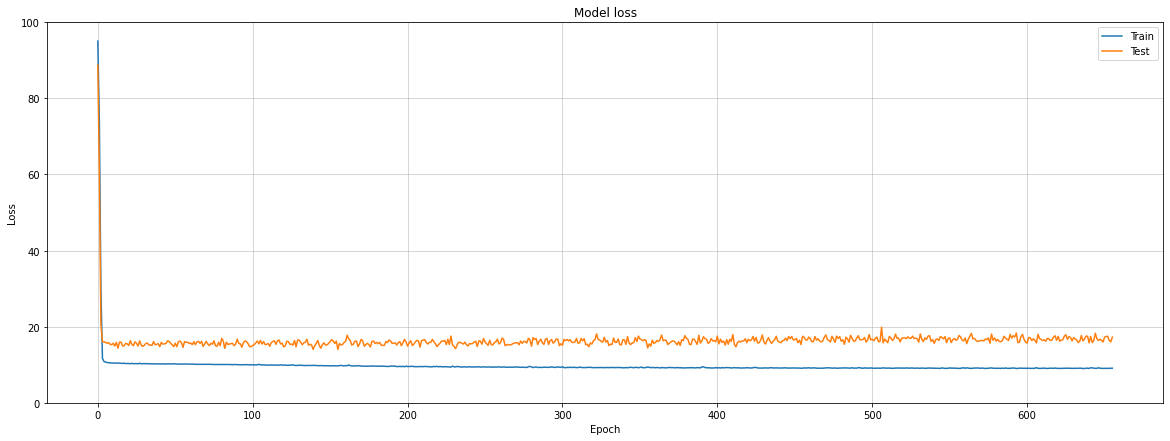

In [47]:
plot_loss(history)

In [48]:
# Prediction on Validation (Apremont)

y_pred = model.predict(X_val)

In [49]:
val_df['pred'] = y_pred

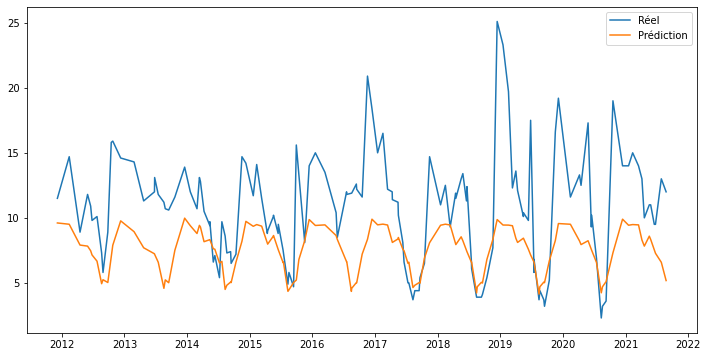

In [50]:
plt.figure(figsize=(12,6))
plt.plot(val_df['date'],val_df['nitrate'],label='Réel')
plt.plot(val_df['date'],val_df['pred'],label='Prédiction')
plt.legend()
plt.show()

In [ ]:
test_df